# <a href="https://colab.research.google.com/github/GR-Tang/IBM-AI0403-Team3/blob/main/TelcoChurnV14.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# importing the libraries needed for fiddling with the dataset

import pixiedust
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams

#setting the charts to be shown inline and using seaborn darkgrid (personal preference)

%matplotlib inline
sns.set_theme(style="darkgrid")

Pixiedust database opened successfully


In [2]:
# importing the necessary libraries for later

# !pip install imblearn # for coaching purposes as some team mates freshly installed conda env and jupyter nb

from imblearn.over_sampling import SMOTE
import xgboost as xgb
from xgboost import plot_tree
from xgboost import plot_importance
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from scipy.stats import sem
import graphviz
from sklearn.ensemble import GradientBoostingClassifier 
from lightgbm import LGBMClassifier
import lightgbm as lgbm

<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject


In [3]:
# getting the dataset and loading it up

raw_df=pixiedust.sampleData('https://raw.githubusercontent.com/GR-Tang/IBM-AI0403-Team3/main/telco-data.csv')

Downloaded 977501 bytes
Creating pandas DataFrame for 'https://raw.githubusercontent.com/GR-Tang/IBM-AI0403-Team3/main/telco-data.csv'. Please wait...
Loading file using 'pandas'
Successfully created pandas DataFrame for 'https://raw.githubusercontent.com/GR-Tang/IBM-AI0403-Team3/main/telco-data.csv'


In [4]:
# checking and verifying the dataset

raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [5]:
# getting the headers to fiddle with the features

raw_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [6]:
# one-hot encodes, note that this is not the most pythonic way of writing, too much repeat
# but is intentional to deal with potential data drift as its easier to read/amend feature by feature

# cleaning up the observation values to prepare for one-hot encoding, and removing pesky spaces for column names 

raw_df['SeniorCitizen']=raw_df['SeniorCitizen'].map({1:'Yes', 0:'No'})
raw_df['MultipleLines']=raw_df['MultipleLines'].map({'Yes':'Yes', 'No':'No','No phone service':'No'})
raw_df['OnlineSecurity']=raw_df['OnlineSecurity'].map({'Yes':'Yes', 'No':'No','No internet service':'No'})
raw_df['OnlineBackup']=raw_df['OnlineBackup'].map({'Yes':'Yes', 'No':'No','No internet service':'No'})
raw_df['DeviceProtection']=raw_df['DeviceProtection'].map({'Yes':'Yes', 'No':'No','No internet service':'No'})
raw_df['TechSupport']=raw_df['TechSupport'].map({'Yes':'Yes', 'No':'No','No internet service':'No'})
raw_df['StreamingTV']=raw_df['StreamingTV'].map({'Yes':'Yes', 'No':'No','No internet service':'No'})
raw_df['StreamingMovies']=raw_df['StreamingMovies'].map({'Yes':'Yes', 'No':'No','No internet service':'No'})
raw_df['InternetService']=raw_df['InternetService'].map({'DSL':'DSL', 'No':'No','Fiber optic':'Fiber_Optic'})
raw_df['Contract']=raw_df['Contract'].map({'Month-to-month':'Month_to_month', 'One year':'One_year',
                                           'Two year':'Two_year'})
raw_df['PaymentMethod']=raw_df['PaymentMethod'].map({'Bank transfer (automatic)':'Bank_transfer_automatic',
                                                     'Credit card (automatic)':'Credit_card_automatic',
                                                     'Electronic check':'Electronic_cheque',
                                                     'Mailed check':'Mailed_cheque'})

# instead of creating each one-hot columns manually, we can use pandas get_dummies to do it. 
# But pandas have a habit of storing them in int32 (smaller malloc maybe?) that pixiedust cannot display, 
# we have to specify and cast type to int64 

raw_df=pd.get_dummies(raw_df, columns=['gender','Partner','SeniorCitizen','Dependents','PhoneService','MultipleLines',
                                       'InternetService','OnlineSecurity','OnlineBackup','DeviceProtection',
                                       'TechSupport','StreamingTV','StreamingMovies','Contract','PaperlessBilling',
                                       'PaymentMethod'], dtype='int64')

# keeping Churn as binary class due to it being target feature instead of one-hot encoding it

raw_df['Churn']=raw_df['Churn'].map({'Yes': 1,'No': 0})
raw_df['TotalCharges']=raw_df['TotalCharges'].replace({' ':'0'}).astype(float)
raw_df.drop(columns=['customerID'], inplace = True)

In [7]:
# grouping tenure and monthlycharges into bins as discussed in group

raw_df['Bintenure']=(raw_df['tenure']/6).apply(np.ceil).astype("int64")
raw_df['BinMonthlyCharges']=(raw_df['MonthlyCharges']/10).apply(np.ceil).astype("int64")
raw_df['BinTotalCharges']=(raw_df['TotalCharges']/500).apply(np.ceil).astype("int64")

In [8]:
# shifting the target column to position 0 for ease of reference later

churn_df = raw_df['Churn']
raw_df.drop(columns=['Churn'], inplace = True)
raw_df.insert(0, 'Churn', churn_df)


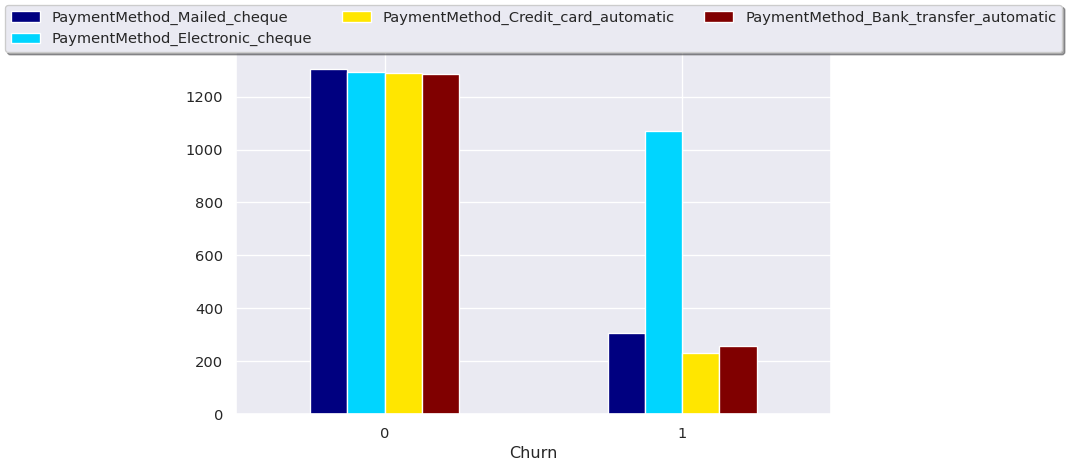

In [ ]:
# can skip, coaching team mate to use pixiedust by IBM for data visualisation... which was why pixiedust was imported 

display(raw_df)

In [10]:
# dropping unwanted columns after discussion with group

imbaldrop2bin_df= raw_df.drop(columns=['gender_Male', 'gender_Female','MonthlyCharges','TotalCharges','tenure'])
imbaldrop7bin_df=imbaldrop2bin_df.drop(columns=['PhoneService_Yes','PhoneService_No','StreamingTV_Yes',
                                                'StreamingTV_No','StreamingMovies_Yes','StreamingMovies_No',
                                                'MultipleLines_Yes','MultipleLines_No','BinTotalCharges'])

In [11]:
# verifying we have the correct features

imbaldrop2bin_df.head()

,Churn,Partner_No,Partner_Yes,SeniorCitizen_No,SeniorCitizen_Yes,Dependents_No,Dependents_Yes,PhoneService_No,PhoneService_Yes,MultipleLines_No,...,Contract_Two_year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank_transfer_automatic,PaymentMethod_Credit_card_automatic,PaymentMethod_Electronic_cheque,PaymentMethod_Mailed_cheque,Bintenure,BinMonthlyCharges,BinTotalCharges
0,0,0,1,1,0,1,0,1,0,1,...,0,0,1,0,0,1,0,1,3,1
1,0,1,0,1,0,1,0,0,1,1,...,0,1,0,0,0,0,1,6,6,4
2,1,1,0,1,0,1,0,0,1,1,...,0,0,1,0,0,0,1,1,6,1
3,0,1,0,1,0,1,0,1,0,1,...,0,1,0,1,0,0,0,8,5,4
4,1,1,0,1,0,1,0,0,1,1,...,0,0,1,0,0,1,0,1,8,1


In [12]:
# noticed target data is imbalanced, can either undersample (randomly reduce negatives to match the number of positives) 
# or oversample (randomly generate synthetic positives to match the number of negatives)
# however, almost all articles points to balancing after splitting into test/train sets. 

pd.value_counts(raw_df['Churn'])

0    5174
1    1869
Name: Churn, dtype: int64

In [13]:
# Selecting the CSV file to use as the group had several ideas

raw_df=imbaldrop2bin_df

In [14]:
# taking 10% of data as test data (holding data), the rest to train 

train_df, test_df = train_test_split(raw_df, test_size=0.1, stratify=raw_df['Churn'], random_state=55)

# printing to check size (good old days of adding a printf to every line of C program codes for debug haha)

print("Size of the training dataset = ", train_df.shape)
print("Size of the testing dataset = ", test_df.shape)

# show sample of the dataset to verify

print("\n\nSample of the training dataset \n")
train_df.head()

Size of the training dataset =  (6338, 38)
Size of the testing dataset =  (705, 38)


Sample of the training dataset 



,Churn,Partner_No,Partner_Yes,SeniorCitizen_No,SeniorCitizen_Yes,Dependents_No,Dependents_Yes,PhoneService_No,PhoneService_Yes,MultipleLines_No,...,Contract_Two_year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank_transfer_automatic,PaymentMethod_Credit_card_automatic,PaymentMethod_Electronic_cheque,PaymentMethod_Mailed_cheque,Bintenure,BinMonthlyCharges,BinTotalCharges
766,0,1,0,1,0,1,0,0,1,0,...,0,0,1,0,0,0,1,4,8,4
2054,1,1,0,1,0,1,0,0,1,0,...,0,0,1,0,0,1,0,1,5,1
1039,1,0,1,1,0,1,0,0,1,1,...,0,0,1,0,0,1,0,7,8,7
1814,0,0,1,1,0,0,1,0,1,1,...,1,1,0,0,0,0,1,2,2,1
1440,0,0,1,1,0,0,1,0,1,1,...,0,1,0,0,1,0,0,2,2,1


In [15]:
# counting the value of positive target value

pd.value_counts(train_df['Churn'])

0    4656
1    1682
Name: Churn, dtype: int64

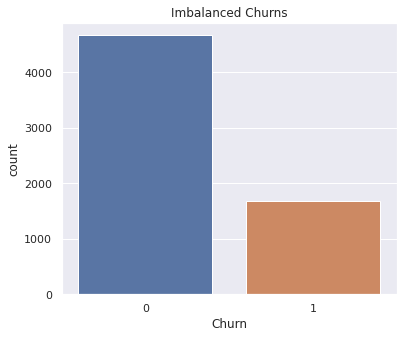

In [16]:
# plot and show the current imbalance

rcParams['figure.figsize'] = 6,5
sns.countplot(x='Churn', data=train_df)
plt.title('Imbalanced Churns')
plt.show()

In [17]:
# oversampling NOTE - Choose the one above or this, do not use both
# sampling strategy was intentionally set at ratio of 2:3 after discussion, 
# coz if ratio set at 1:1, we will artifically increase positive target value by more than 100% of itself, 
# which will result in higher inaccuracy

sm = SMOTE(sampling_strategy=0.6667, random_state=55)

# separating training data into target feature and others, smote it and concatenate it back into train_df

oversam_train_X, oversam_train_Y = sm.fit_sample(train_df.drop('Churn', axis=1), train_df['Churn'])
train_df = pd.concat([pd.DataFrame(oversam_train_Y), pd.DataFrame(oversam_train_X)], axis=1)

In [18]:
# counting the target feature to see if its better

pd.value_counts(train_df['Churn'])

0    4656
1    3104
Name: Churn, dtype: int64

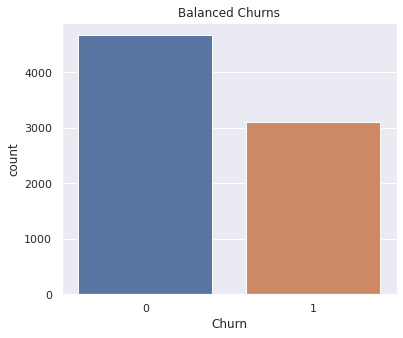

In [19]:
# Now plot and show the corrected balance
# looks better but not what i would prefer, possibly combination of over then under sampling would be better
# team is happy with this, as the project deadline is only one week, we carry on as PoC instead of further experimenting

rcParams['figure.figsize'] = 6,5
sns.countplot(x='Churn', data=train_df)
plt.title('Balanced Churns')
plt.show()

In [20]:
# define target column for both test and train dataset

train_X, train_Y = train_df.iloc[:,1:],train_df.iloc[:,0]
test_X, test_Y = test_df.iloc[:,1:],test_df.iloc[:,0]

In [21]:
# selecting the model, parameters used for the first run is to suppress error messages
# XGBoost was selected as the group's first run in Watson Studio recommended XGBoost

model1 = xgb.XGBClassifier(use_label_encoder=False, verbosity=0)

# fitting the model to the training dataset

model1.fit(train_X, train_Y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=0)

In [22]:
# writing a function to simplify/standardise testing of machine learning models using a set of evaluation metrics
# and graphs for visualisation and comparison. Number of cross validation K-folds is set in arg as opposed to hardcoded.
# This is to enable recycling of function for other projects in the future.

def assess_model(model, test_X, test_Y, folds):
    
    # calculating all the evaluation metrics
    
    model_preds = model.predict(test_X)
    accuracy = accuracy_score(test_Y, model_preds)
    model_probs = model.predict_proba(test_X)
    model_probs = model_probs[:, 1]
    model_auc = roc_auc_score(test_Y, model_probs)
    model_fpr, model_tpr, _ = roc_curve(test_Y, model_probs)
    model_precision, model_recall, _ = precision_recall_curve(test_Y, model_probs)
    model_f1 = f1_score(test_Y, model_preds)
    score = cross_val_score(model, train_X, train_Y, cv=folds, scoring='roc_auc')
    
    # display of all calculated metrics... (could have used print(f"{}") on hindsight, wonder did i really forget my C)
    
    print('Model: %s\n' % (model))
    print((folds),'Folds Cross Validation ROC AUC Scores: ', (score))
    print('Mean ROC AUC score: {0:.3f} (+/-{1:.3f})'.format(np.mean(score), sem(score)))
    print('\nTest Set score:')
    print('Accuracy: %.2f' % (accuracy * 100.0))
    print('ROC AUC=%.3f' % (model_auc))
    print('F1=%.3f' % (model_f1))

    
    # plotting confusion matrix
    
    rcParams['figure.figsize'] = 6,5
    fig, ax = plt.subplots()
    cm = confusion_matrix(test_Y, model_preds)
    tp = cm[1,1]
    tn = cm[0,0]
    fp = cm[0,1]
    fn = cm[1,0]
    sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, ax = ax)
    ax.set_title('Confusion Matrix')
    ax.set_xlabel("Predicted class")
    ax.set_ylabel("Actual class")
    plt.show()
    
    # plot roc/precision/recall
    
    rcParams['figure.figsize'] = 10,8
    plt.plot(model_fpr, model_tpr, marker='.', label='ROC')
    plt.plot(model_recall, model_precision, marker='.', label='Recall/Precision')
    plt.xlabel('Recall\nFalse Positive Rate')
    plt.ylabel('Precision\nTrue Positive Rate')
    plt.legend()
    plt.show()

    # plot feature importance
    
    rcParams['figure.figsize'] = 8,8
    feat_importances = pd.Series(model.feature_importances_, index=train_X.columns)
    feat_importances.nlargest(38).plot(kind='barh').invert_yaxis()
 

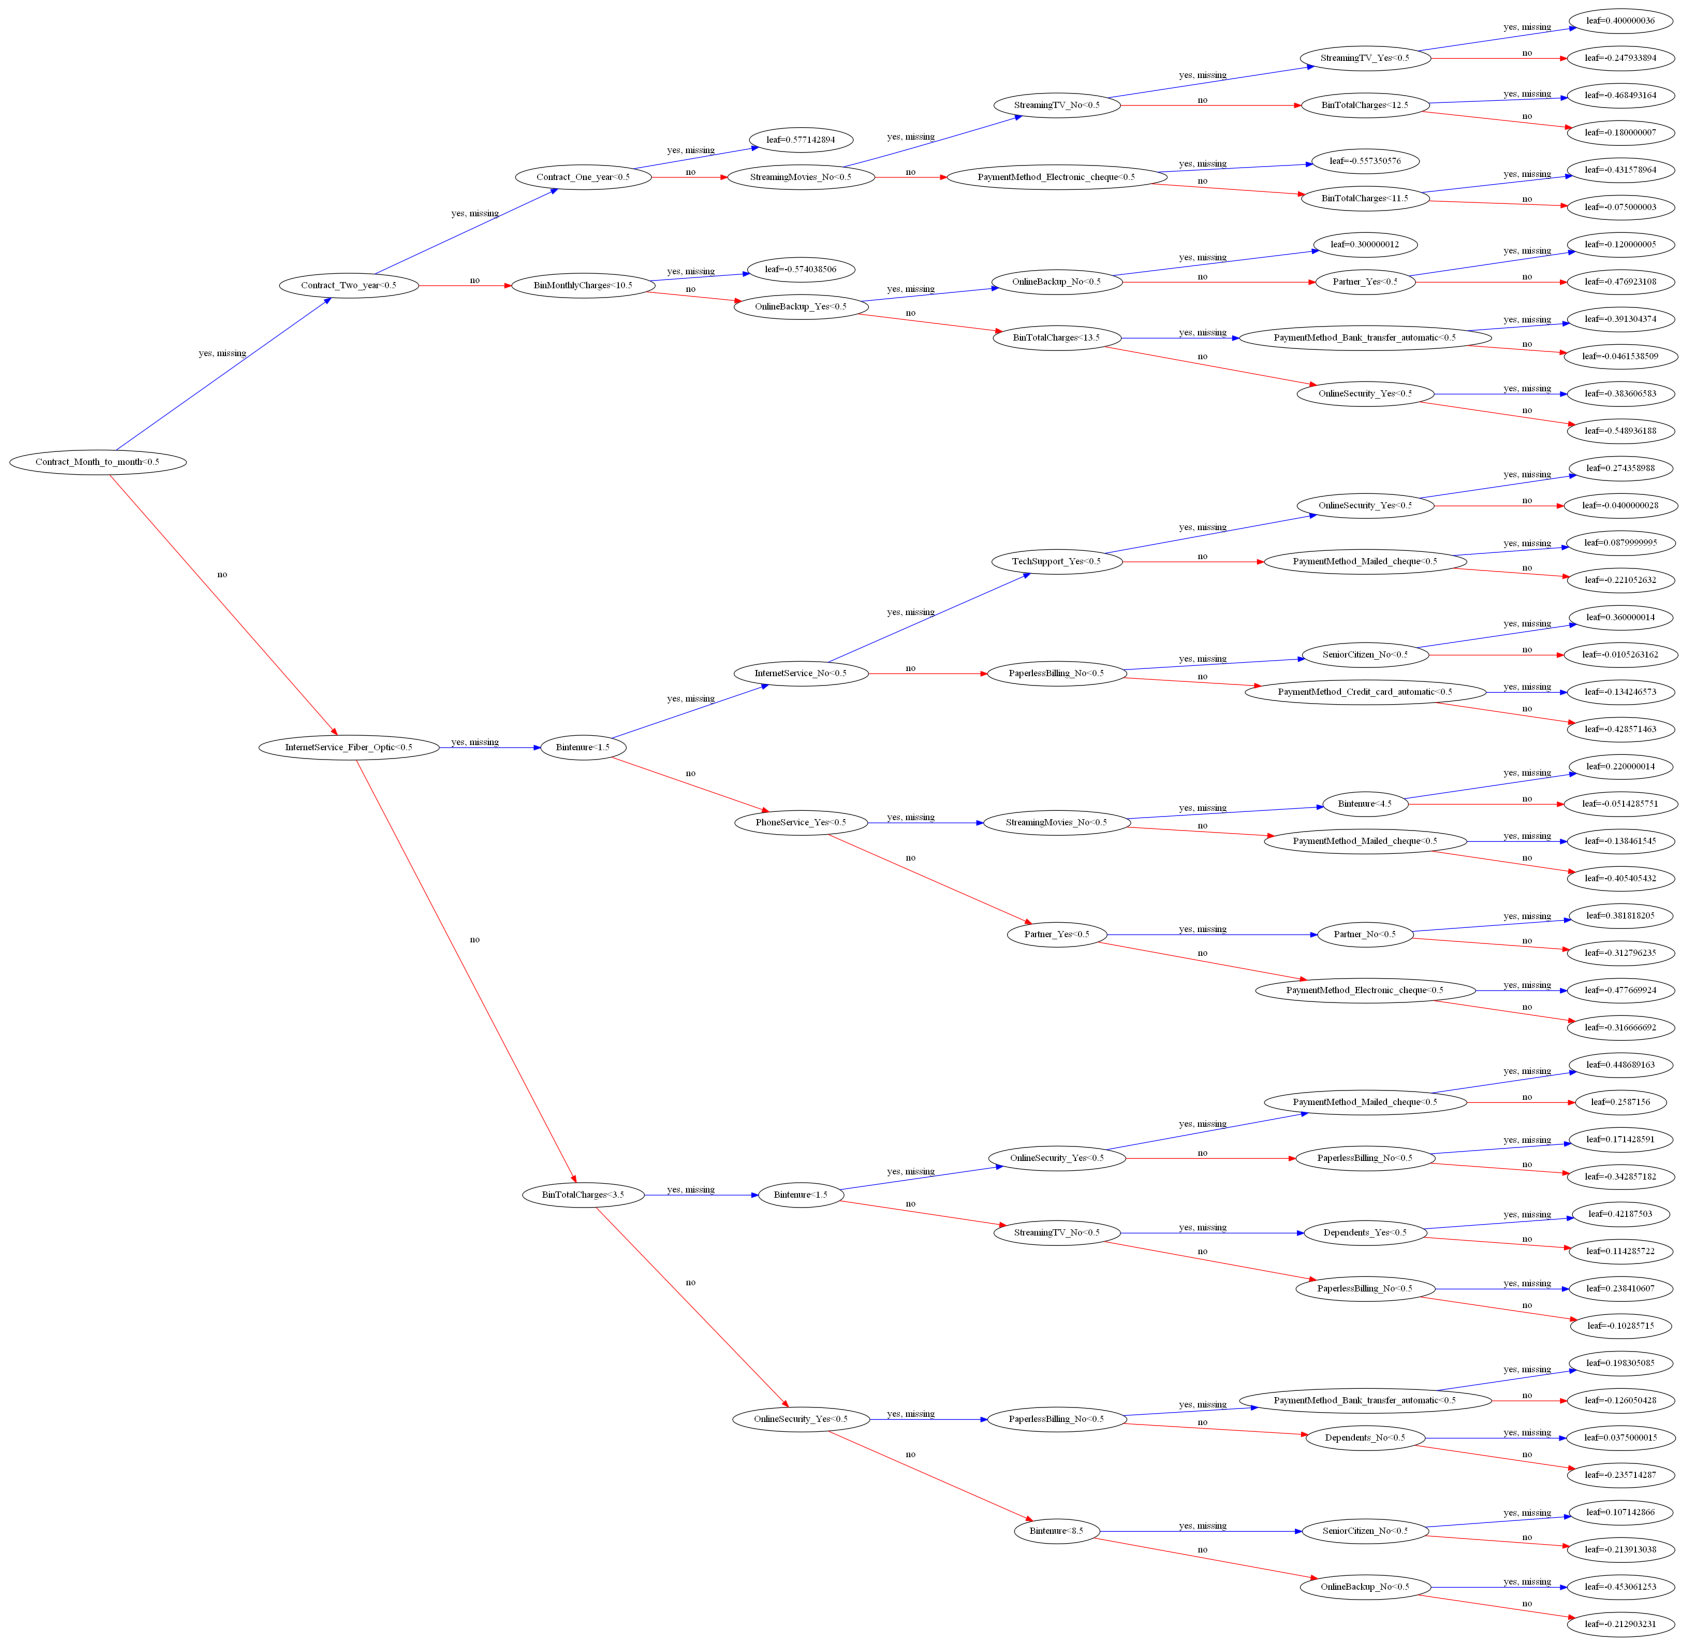

In [23]:
# visualising the decision tree for shits and giggles
# also to show the group how it looks like and help them visualise the concept of entropy vs information gain. 

rcParams['figure.figsize'] = 30,40
xgb.plot_tree(model1, rankdir='LR')
plt.show()

Model: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=0)

3 Folds Cross Validation ROC AUC Scores:  [0.82030262 0.8762952  0.97556376]
Mean ROC AUC score: 0.891 (+/-0.045)

Test Set score:
Accuracy: 79.43
ROC AUC=0.823
F1=0.598


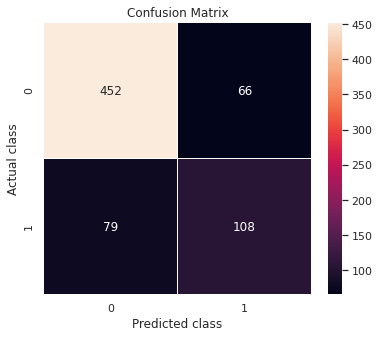

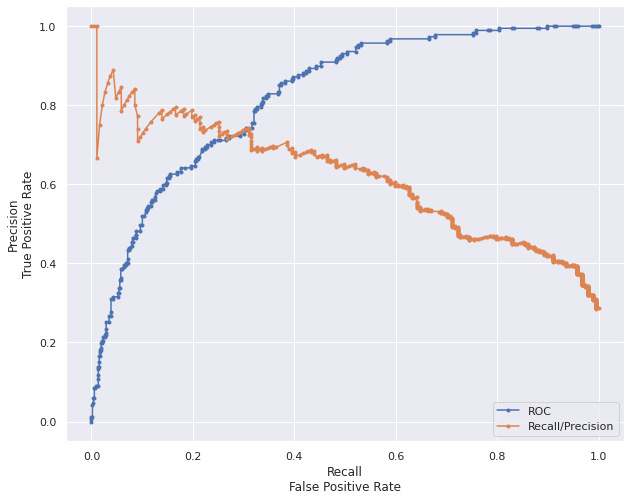

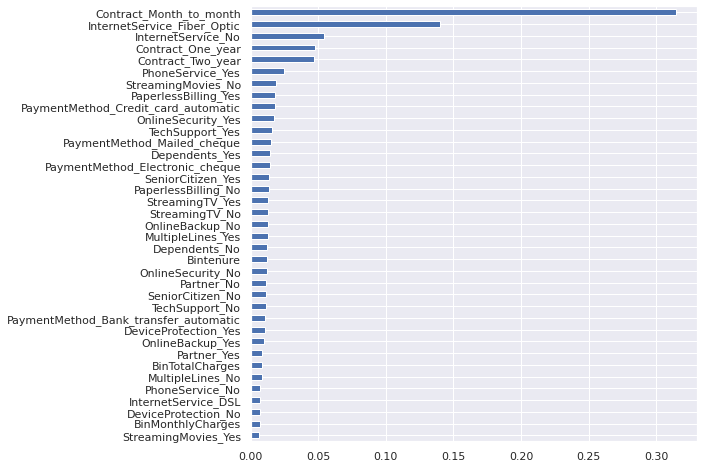

In [24]:
# running the assess model function to get the report cards of the first model

assess_model(model1,test_X,test_Y,3)

In [25]:
# this will take very very long (bob marley:"I've been watching you~~") to run due to the various combinations
# thought of changing cores used but refrained, for portability, not all team mates using laptop/comp with gpu
# edited to reduce number of iterations, from 6 hyperparameters to 4. Wont get the best results but everyone can run it
# have to convert this from personal passion to a proof of concept technical demo... we are running out of time

# selecting the model

model2 = xgb.XGBClassifier(use_label_encoder=False, verbosity=0)

# specifying the parameters - refer to each model's documentation for available options
# some of the same things (like learning rate) are named differently, and have to take note of the acceptable range

param_grid = {'eta':[0.1, 0.2, 0.3, 0.4, 0.5],
              'max_depth':[3, 4, 5, 6, 7],
              'gamma':[0, 3, 6, 9, 12],
              'subsample':[0.1, 0.25, 0.5, 0.75, 1]
}

# running a kfold cross-validation, 3 folds chosen to run in parallel with watson studio (only 3 fold availble there)

kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=55)
grid_search = GridSearchCV(model2, param_grid, scoring='roc_auc', cv=kfold)
grid_result = grid_search.fit(train_X, train_Y)

# summarize results for this grid search

print("Best ROC AUC: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("ROC AUC %f (%f) with: %r" % (mean, stdev, param))

Best ROC AUC: 0.906494 using {'eta': 0.1, 'gamma': 3, 'max_depth': 4, 'subsample': 0.75}
ROC AUC 0.893428 (0.005463) with: {'eta': 0.1, 'gamma': 0, 'max_depth': 3, 'subsample': 0.1}
ROC AUC 0.898901 (0.006719) with: {'eta': 0.1, 'gamma': 0, 'max_depth': 3, 'subsample': 0.25}
ROC AUC 0.902722 (0.006822) with: {'eta': 0.1, 'gamma': 0, 'max_depth': 3, 'subsample': 0.5}
ROC AUC 0.903010 (0.005887) with: {'eta': 0.1, 'gamma': 0, 'max_depth': 3, 'subsample': 0.75}
ROC AUC 0.902260 (0.005718) with: {'eta': 0.1, 'gamma': 0, 'max_depth': 3, 'subsample': 1}
ROC AUC 0.896463 (0.004437) with: {'eta': 0.1, 'gamma': 0, 'max_depth': 4, 'subsample': 0.1}
ROC AUC 0.901266 (0.007193) with: {'eta': 0.1, 'gamma': 0, 'max_depth': 4, 'subsample': 0.25}
ROC AUC 0.905407 (0.007385) with: {'eta': 0.1, 'gamma': 0, 'max_depth': 4, 'subsample': 0.5}
ROC AUC 0.906050 (0.006989) with: {'eta': 0.1, 'gamma': 0, 'max_depth': 4, 'subsample': 0.75}
ROC AUC 0.905750 (0.006645) with: {'eta': 0.1, 'gamma': 0, 'max_depth': 

Model: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.1, gamma=3,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.100000001, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.75,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=0)

3 Folds Cross Validation ROC AUC Scores:  [0.84742424 0.89106311 0.9621587 ]
Mean ROC AUC score: 0.900 (+/-0.033)

Test Set score:
Accuracy: 79.72
ROC AUC=0.846
F1=0.612


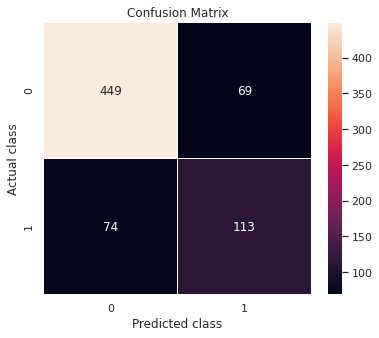

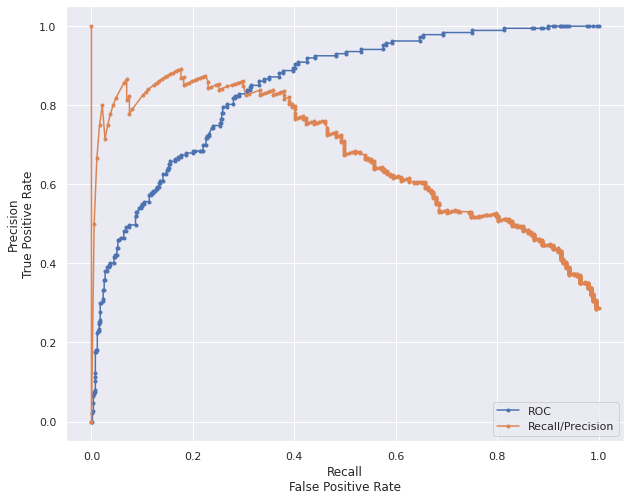

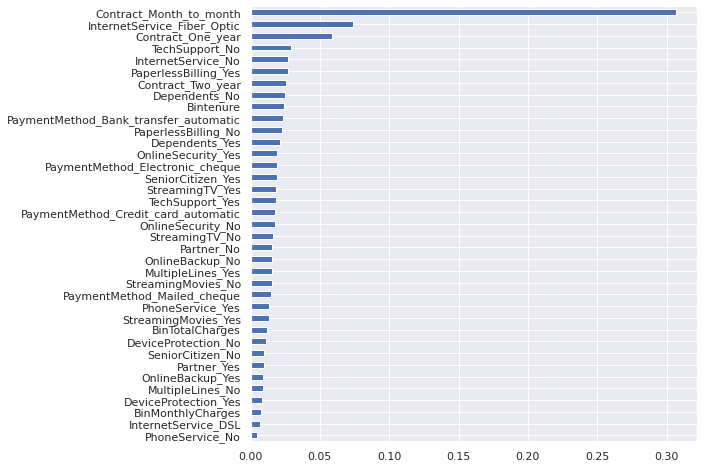

In [26]:
# Refit the model with new optimised parameters

model3 = xgb.XGBClassifier(use_label_encoder=False, verbosity=0, **grid_result.best_params_)

# fitting the model to the training dataset

model3.fit(train_X, train_Y)

# assess the model with optimised parameters

assess_model(model3,test_X,test_Y,3)

In [27]:
# Selecting the alternative model and fitting it with train data, using default params 
# Watson Studio suggested 3 estimators in the gradient boosting family. 
# As tech demo to code in parallel and looking under the hood, group decided to follow suit. would have like to try others.

# selecting and fitting the next estimator (Light GBM by Microsoft)

model4 = LGBMClassifier()
model4.fit(train_X, train_Y)

LGBMClassifier()

Model: LGBMClassifier()

3 Folds Cross Validation ROC AUC Scores:  [0.83664369 0.88647654 0.96717501]
Mean ROC AUC score: 0.897 (+/-0.038)

Test Set score:
Accuracy: 79.72
ROC AUC=0.845
F1=0.610


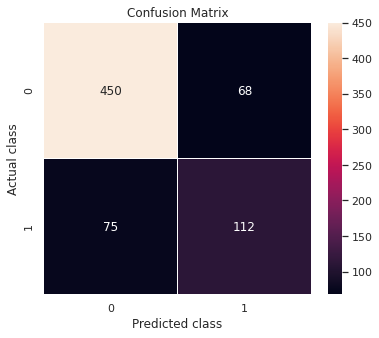

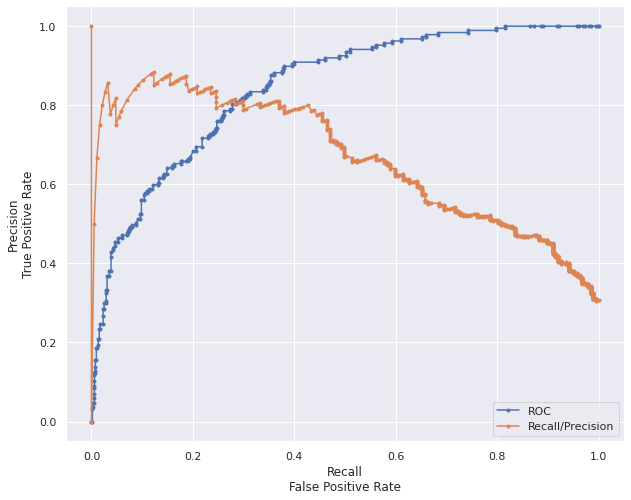

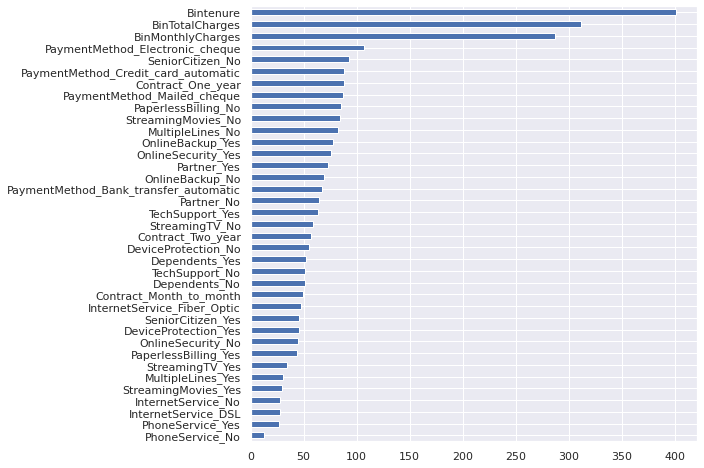

In [28]:
# assess the default LGBM model to get a baseline scoring

assess_model(model4,test_X,test_Y,3)

In [29]:
# perform gridsearchcv LGBM model using a few parameters, 
# this process takes very long since it will run all the possible different combinations of the parameters
# params which default is better: 'boosting_type':['gbdt', 'rf'],'learning_rate':[0.025, 0.050, 0.075, 0.1, 0.2]
# some parameters have been left out due to irritating and unnecessary verbose warnings, steps are the same

# selecting model

model5 = LGBMClassifier(verbosity=-1)

# setting parameters grid - to do: after the PoC, run a grid search that actually improve the scores

param_grid = {'learning_rate':[0.025, 0.05, 0.1, 0.2, 0.3],
              'extra_trees':[True, False],
              'max_bin':[10, 55, 155, 255, 280],
              'max_delta_step':[-1, 10, 20, 30, 50]
}

# same same but different, refer to the xgboost hpo (now with lgbm model)

kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=55)
grid_search = GridSearchCV(model5, param_grid, scoring='roc_auc', cv=kfold)
grid_result = grid_search.fit(train_X, train_Y)

# summarize results

print("Best ROC AUC: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("ROC AUC %f (%f) with: %r" % (mean, stdev, param))

Best ROC AUC: 0.904017 using {'extra_trees': False, 'learning_rate': 0.05, 'max_bin': 55, 'max_delta_step': 10}
ROC AUC 0.895563 (0.009134) with: {'extra_trees': True, 'learning_rate': 0.025, 'max_bin': 10, 'max_delta_step': -1}
ROC AUC 0.895250 (0.009159) with: {'extra_trees': True, 'learning_rate': 0.025, 'max_bin': 10, 'max_delta_step': 10}
ROC AUC 0.895250 (0.009159) with: {'extra_trees': True, 'learning_rate': 0.025, 'max_bin': 10, 'max_delta_step': 20}
ROC AUC 0.895250 (0.009159) with: {'extra_trees': True, 'learning_rate': 0.025, 'max_bin': 10, 'max_delta_step': 30}
ROC AUC 0.895250 (0.009159) with: {'extra_trees': True, 'learning_rate': 0.025, 'max_bin': 10, 'max_delta_step': 50}
ROC AUC 0.895924 (0.008267) with: {'extra_trees': True, 'learning_rate': 0.025, 'max_bin': 55, 'max_delta_step': -1}
ROC AUC 0.895936 (0.008271) with: {'extra_trees': True, 'learning_rate': 0.025, 'max_bin': 55, 'max_delta_step': 10}
ROC AUC 0.895936 (0.008271) with: {'extra_trees': True, 'learning_rat

In [30]:
# select and fit lgbm model with optimised parameters 

model6 = LGBMClassifier(verbosity=-1, **grid_result.best_params_)
model6.fit(train_X, train_Y)

LGBMClassifier(extra_trees=False, learning_rate=0.05, max_bin=55,
               max_delta_step=10, verbosity=-1)

Model: LGBMClassifier(extra_trees=False, learning_rate=0.05, max_bin=55,
               max_delta_step=10, verbosity=-1)

3 Folds Cross Validation ROC AUC Scores:  [0.84473206 0.8867321  0.95488881]
Mean ROC AUC score: 0.895 (+/-0.032)

Test Set score:
Accuracy: 79.72
ROC AUC=0.842
F1=0.604


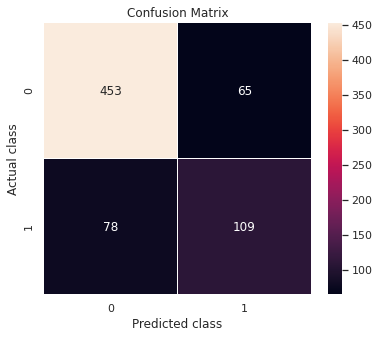

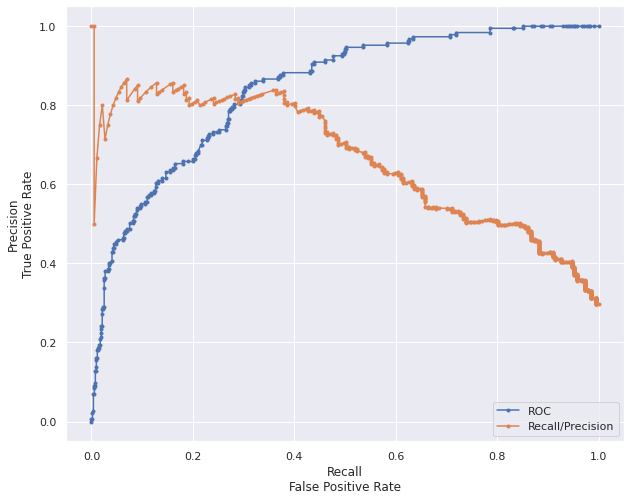

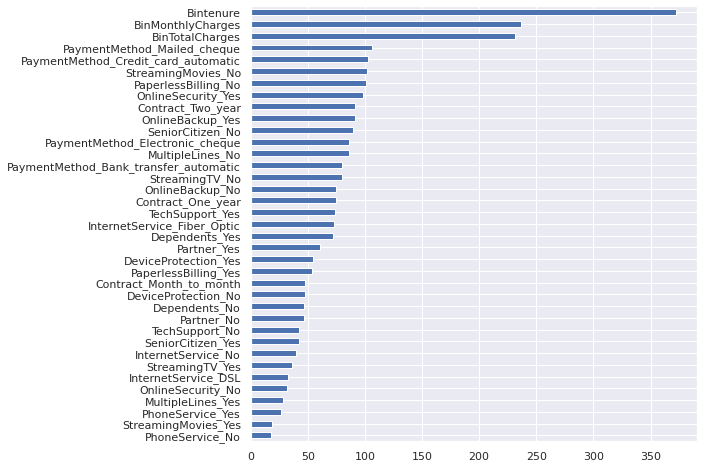

In [31]:
# assess updated LGBM model with optimised parameters

assess_model(model6,test_X,test_Y,3)

In [32]:
# the next estimator Watson Studio recommended. Hoping to have a log regrsn or even naive bayes... 

model7 = GradientBoostingClassifier()
model7.fit(train_X, train_Y)

GradientBoostingClassifier()

Model: GradientBoostingClassifier()

3 Folds Cross Validation ROC AUC Scores:  [0.84637339 0.8873232  0.94894776]
Mean ROC AUC score: 0.894 (+/-0.030)

Test Set score:
Accuracy: 79.29
ROC AUC=0.846
F1=0.608


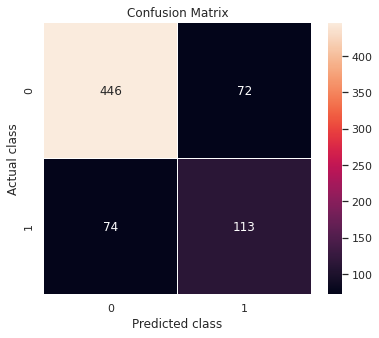

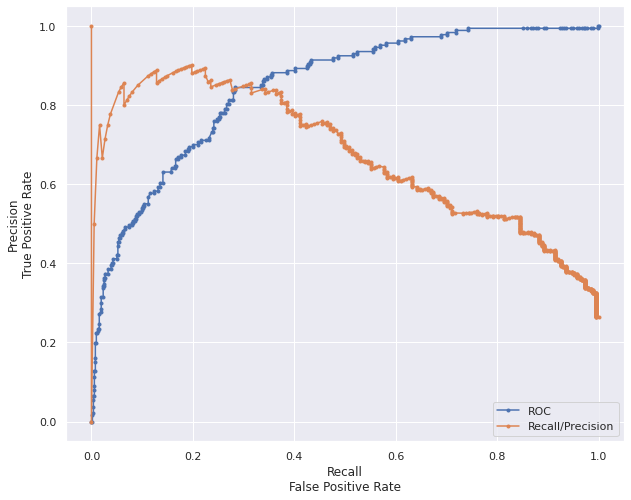

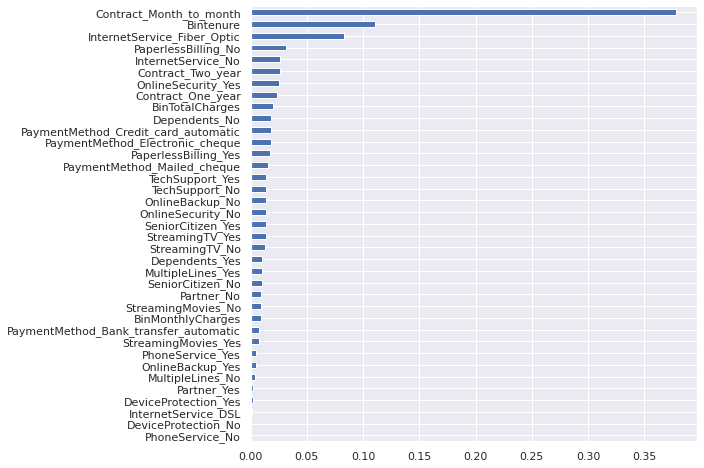

In [33]:
# assess updated LGBM model with optimised parameters

assess_model(model7,test_X,test_Y,3)

In [34]:
# perform gridsearch for GBclassifier model using a few parameters, 
# same thing as before...

# selecting model

model8 = GradientBoostingClassifier()

# setting parameter grid

param_grid = {'learning_rate':[0.01, 0.05, 0.1, 0.2, 0.3],
              'n_estimators':[80, 90, 100, 110, 120],
              'subsample':[0.01, 0.25, 0.5, 0.75, 1.0],
              'max_depth':[1, 2, 3, 5, 7]
}

# cross validate

kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=55)
grid_search = GridSearchCV(model8, param_grid, scoring='roc_auc', cv=kfold)
grid_result = grid_search.fit(train_X, train_Y)

# summarize results

print("Best ROC AUC: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("ROC AUC %f (%f) with: %r" % (mean, stdev, param))

Best ROC AUC: 0.904988 using {'learning_rate': 0.3, 'max_depth': 2, 'n_estimators': 120, 'subsample': 0.75}
ROC AUC 0.838173 (0.010704) with: {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 80, 'subsample': 0.01}
ROC AUC 0.831051 (0.008530) with: {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 80, 'subsample': 0.25}
ROC AUC 0.817657 (0.008977) with: {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 80, 'subsample': 0.5}
ROC AUC 0.816341 (0.008392) with: {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 80, 'subsample': 0.75}
ROC AUC 0.812896 (0.007660) with: {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 80, 'subsample': 1.0}
ROC AUC 0.839528 (0.009542) with: {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 90, 'subsample': 0.01}
ROC AUC 0.829176 (0.008256) with: {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 90, 'subsample': 0.25}
ROC AUC 0.823774 (0.010313) with: {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 90, 'subsampl

Model: GradientBoostingClassifier(learning_rate=0.3, max_depth=2, n_estimators=120,
                           subsample=0.75)

3 Folds Cross Validation ROC AUC Scores:  [0.84358689 0.88969913 0.96866806]
Mean ROC AUC score: 0.901 (+/-0.037)

Test Set score:
Accuracy: 80.14
ROC AUC=0.843
F1=0.609


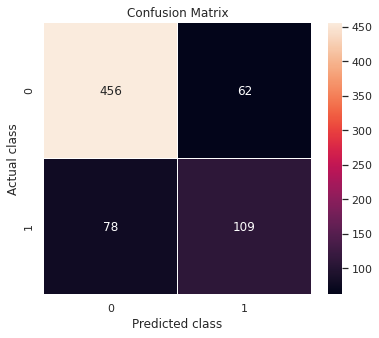

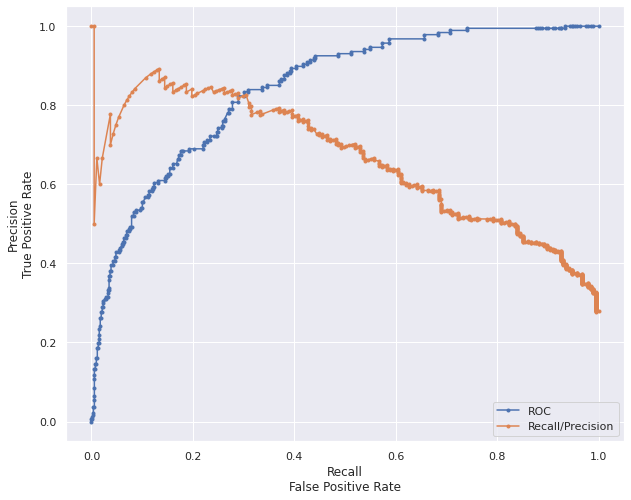

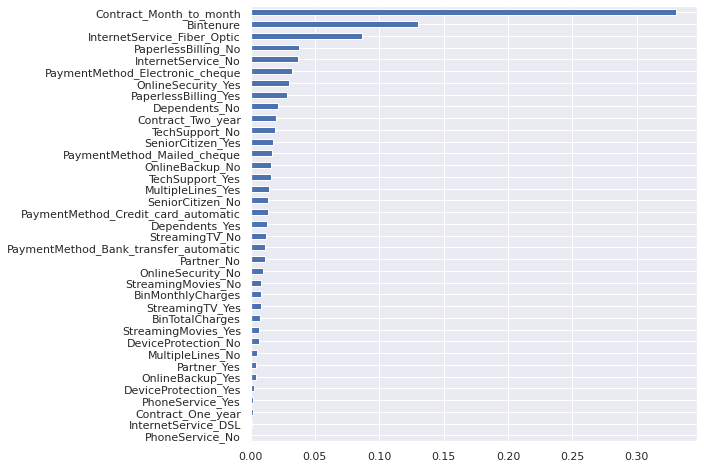

In [35]:
# selecting and fitting with best param from gridsearch

model9 = GradientBoostingClassifier(**grid_result.best_params_)
model9.fit(train_X, train_Y)

# assessing model

assess_model(model9,test_X,test_Y,3)

In [36]:
# fun part. deployment of trained model
# from above models, team chosen XGBoost to be deployed

# fitting XGboost model with custom parameters

model10=xgb.XGBClassifier(use_label_encoder=False, verbosity=0, eta=0.1, max_depth=4, gamma=3, subsample=0.75)

model10.fit(train_X, train_Y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.1, gamma=3,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.100000001, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.75,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=0)

In [37]:
%%writefile telco_churn_class.py

# creating a py file for the model, note that the %% command needs to be in the first line
# due to time contraints, using bentoML to simplify process

from bentoml import BentoService, api, env, artifacts
from bentoml.adapters import DataframeInput
from bentoml.service.artifacts.common import PickleArtifact

@artifacts([PickleArtifact('model')])
@env(conda_dependencies=["scikit-learn"])


class TelcoChurnClassifier(BentoService):

    @api(input=DataframeInput(), batch=True)
    def predict(self, df):
        return self.artifacts.model.predict(df)


Writing telco_churn_class.py


In [38]:
# with the newly created py file in same directory, import the object 

from telco_churn_class import TelcoChurnClassifier

# Create a iris classifier service instance

telco_churn_class_service = TelcoChurnClassifier()

# Pack the newly trained model artifact

telco_churn_class_service.pack('model', model10)

# Save the prediction service to disk for model serving

saved_path = telco_churn_class_service.save()

[2021-03-11 16:29:14,880] INFO - Detected zipimporter <zipimporter object "E:\Anaconda3\lib\site-packages\locket-0.2.1-py3.8.egg\">
[2021-03-11 16:29:20,141] INFO - BentoService bundle 'TelcoChurnClassifier:20210311162919_BC84BD' saved to: C:\Users\night/bentoml/repository/TelcoChurnClassifier\20210311162919_BC84BD
